In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [2]:
#read df
df = pd.read_csv(r'../Final Data/Final_Data.csv')
wheat_price = pd.read_csv(r'../Cleaned Data/Wheat_Price_FRED_clean.csv')
#add new wheat prie data
wheat_price = wheat_price.rename(columns={"PWHEAMTUSDM": "Wheat_Price"})
df = pd.merge(df, wheat_price[['observation_date', 'Wheat_Price']], left_on='date', right_on='observation_date', how='left').drop(['observation_date','wheat_price'], axis=1).rename(columns={'Wheat_Price': 'wheat_price'})

In [3]:
#creat log return data
df['date'] = pd.to_datetime(df['date'])
exclude_cols = ['date', 'avg_temp', 'drought_idx']
cols_to_logret = [col for col in df.columns if col not in exclude_cols]
logret_df = df[['date']].copy()
for col in cols_to_logret:
    logret_df[col + '_logret'] = (np.log(df[col]) - np.log(df[col].shift(1)))*100

#add unchanged vars
logret_df['avg_temp'] = df['avg_temp']
logret_df['drought_idx'] = df['drought_idx']
logret_df['wheat_price_logret_future'] = logret_df['wheat_price_logret'].shift(-1)
logret_df = logret_df.dropna()
logret_df =  logret_df.set_index("date")   
logret_df.head()

,fertilizer_idx_logret,cpi_logret,commodity_imp_idx_logret,commodity_exp_idx_logret,flour_price_logret,corn_price_logret,crude_oil_price_logret,wheat_price_logret,avg_temp,drought_idx,wheat_price_logret_future
date,,,,,,,,,,,
1990-02-01,4.862365,0.391390,0.215983,-0.632247,-1.593659,0.371031,-3.335866,-4.246455,-1.965352,14.6,-2.777957
1990-03-01,-0.417189,0.467655,-0.324149,0.211193,1.197619,3.278994,-8.098541,-2.777957,4.222106,11.2,1.860522
1990-04-01,-0.418937,0.233010,-0.869571,0.315956,-0.397615,7.589858,-10.106481,1.860522,9.391660,8.0,-6.669145
1990-05-01,-2.809891,0.155039,-0.437637,0.210084,1.188133,2.298939,-1.255818,-6.669145,13.738063,7.1,-9.555649
1990-06-01,-2.980063,0.617763,-0.439561,-0.210084,1.949379,-0.978787,-8.601287,-9.555649,19.995775,7.3,-8.185102


In [4]:
#create test and train data (train on 1990 - 2018, test on 2018-2025)
logret_df_train_data = logret_df.loc[:'2018-01-01']
logret_df_test_data = logret_df.loc['2018-02-01':]

#run autoregressive model (4 lags)
model_wheat = AutoReg(logret_df_train_data["wheat_price_logret_future"], lags=4,
                      exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()

#forecast the ar model
forecast_steps = len(logret_df_test_data)
forecast_result = model_wheat.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog_oos = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']])

forecast_result_mean  = forecast_result.predicted_mean

# Confidence intervals
forecast_result_conf_int = forecast_result.conf_int()
print("Predicted values:\n", forecast_result_mean)
print("Confidence intervals:\n", forecast_result_conf_int)

Predicted values:
 2018-02-01    2.607461
2018-03-01   -0.374686
2018-04-01   -0.445377
2018-05-01   -0.059316
2018-06-01    0.789687
                ...   
2024-08-01   -0.796184
2024-09-01   -0.254983
2024-10-01   -0.352061
2024-11-01    0.603212
2024-12-01    0.227903
Freq: MS, Name: predicted_mean, Length: 83, dtype: float64
Confidence intervals:
                 lower      upper
2018-02-01 -10.048162  15.263084
2018-03-01 -13.421846  12.672474
2018-04-01 -13.493786  12.603032
2018-05-01 -13.117388  12.998756
2018-06-01 -12.283268  13.862641
...               ...        ...
2024-08-01 -13.871402  12.279034
2024-09-01 -13.330201  12.820235
2024-10-01 -13.427279  12.723157
2024-11-01 -12.472006  13.678430
2024-12-01 -12.847315  13.303121

[83 rows x 2 columns]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


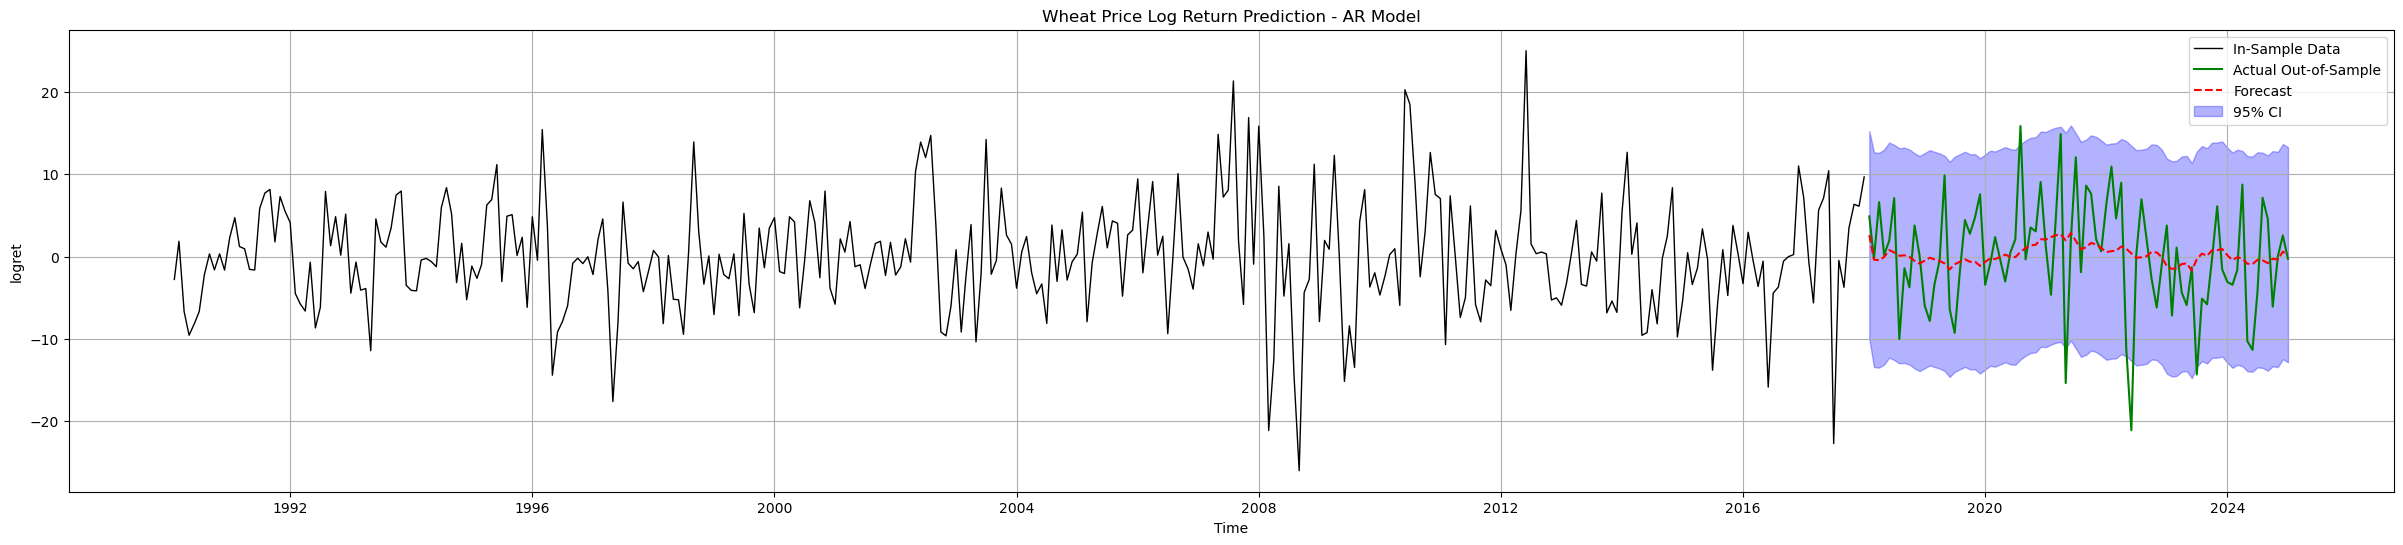

In [5]:
# Plot actual vs forecasted values for ar model
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, forecast_result_mean, label="Forecast", color="red", linestyle="dashed")
#Plot confidence intervals
plt.fill_between(logret_df_test_data.index, forecast_result_conf_int.lower, forecast_result_conf_int.upper, color="blue", alpha=0.3, label="95% CI")

#Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("Wheat Price Log Return Prediction - AR Model")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

#find best ARIMA model parameters for full dataset
best_aic = float('inf')
best_order = None

#test for range of (p,d,q) order
for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                #model with exogenous features
                arima_model_wheat = ARIMA(logret_df["wheat_price_logret_future"], order=(p,d,q),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()
                if arima_model_wheat.aic < best_aic:
                    best_aic = arima_model_wheat.aic
                    best_order = (p, d, q)
            except:
                continue

#print best model results
print(f"Best ARIMA order: {best_order}")
best_arima = ARIMA(logret_df["wheat_price_logret_future"], order = best_order,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()
print('\n',best_arima.summary())

Best ARIMA order: (1, 0, 2)

                                    SARIMAX Results                                   
Dep. Variable:     wheat_price_logret_future   No. Observations:                  419
Model:                        ARIMA(1, 0, 2)   Log Likelihood               -1370.513
Date:                       Sun, 11 May 2025   AIC                           2759.025
Time:                               16:48:17   BIC                           2795.366
Sample:                                    0   HQIC                          2773.390
                                       - 419                                         
Covariance Type:                         opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9438      0.369     -2.561      0.010      -1.666      -0.221
cor

In [7]:
#run best ARIMA model on training data
arima_train=ARIMA(logret_df_train_data["wheat_price_logret_future"], order = best_order,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit()
#forecast
arima_forecast = arima_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']])
arima_forecast_result_mean  = arima_forecast.predicted_mean

print("Predicted values:\n", arima_forecast_result_mean)

Predicted values:
 2018-02-01    3.155446
2018-03-01   -0.211028
2018-04-01    0.192964
2018-05-01    0.359572
2018-06-01    1.187275
                ...   
2024-08-01   -1.172696
2024-09-01   -0.250114
2024-10-01   -0.644754
2024-11-01    0.780504
2024-12-01   -0.183072
Freq: MS, Name: predicted_mean, Length: 83, dtype: float64


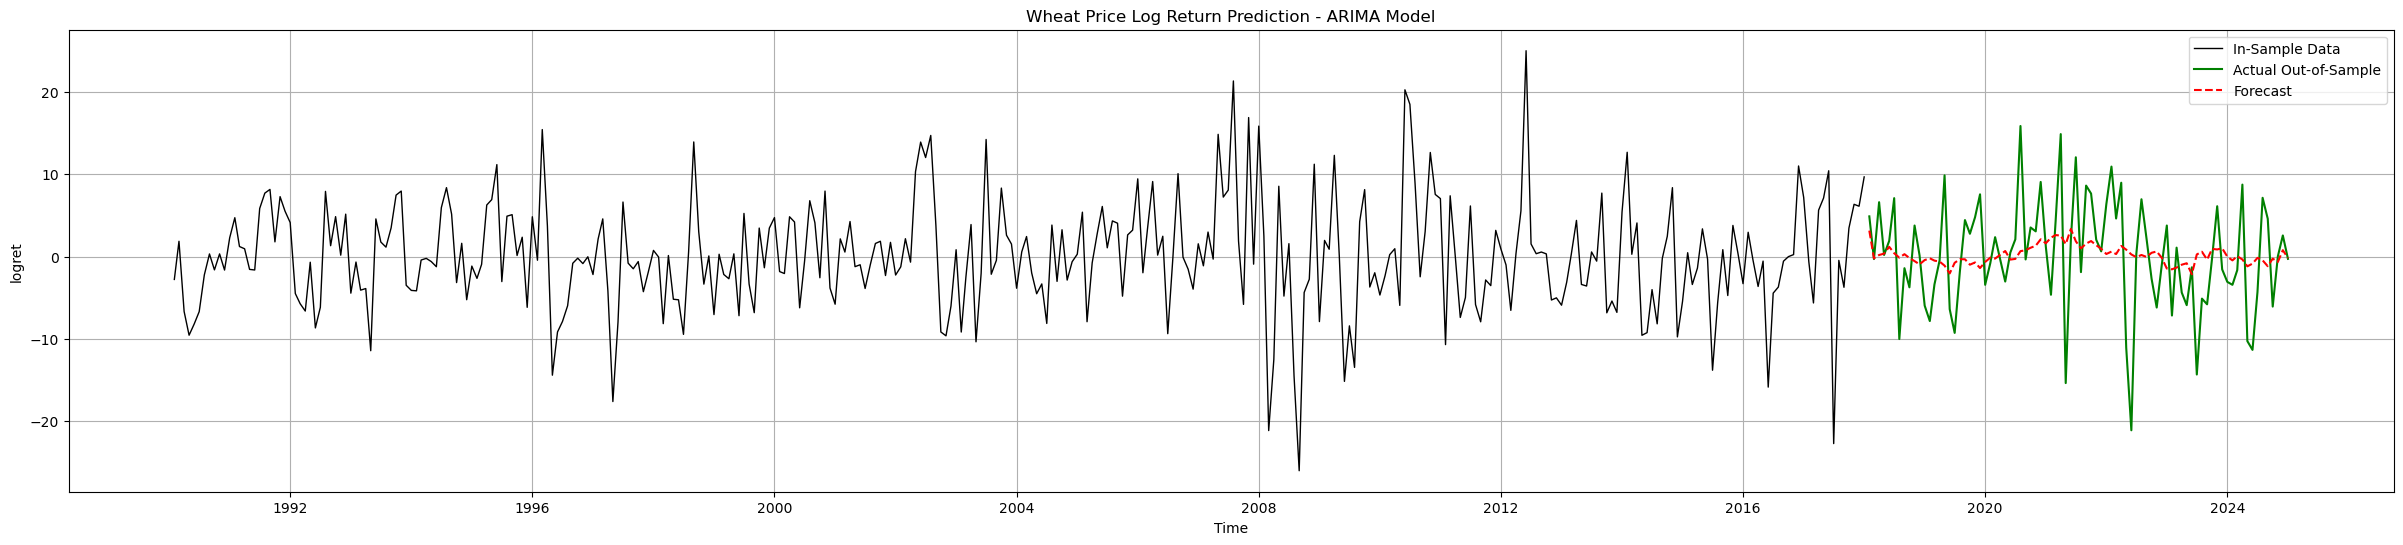

In [8]:
#plot ARIMA forecast
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, arima_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("Wheat Price Log Return Prediction - ARIMA Model")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#find best SARIMAX parameters
best_aic = float('inf')
best_order = None
best_seasonal = None

#test range of (p,d,q) order and range of seasonal (P,D,Q) order
for P in range(2):
    for D in range(2):
        for Q in range(2):
            for p in range(3):
                for d in range(2):
                    for q in range(3):
                        try:
                            #run sarimax model
                            sarimax_model_wheat = SARIMAX(logret_df["wheat_price_logret_future"], order=(p,d,q),seasonal_order=(P, D, Q, 12),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit(disp=False)
                            if sarimax_model_wheat.aic < best_aic:
                                best_aic = sarimax_model_wheat.aic
                                best_order = (p, d, q)
                                best_seasonal = (P,D,Q,12)
                        except:
                            continue

#print best model summary
print(f"Best SARIMAX order: {best_order}x{best_seasonal}")
best_sarimax = SARIMAX(logret_df["wheat_price_logret"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit(disp=False)
print('\n',best_sarimax.summary())

Best SARIMAX order: (1, 0, 2)x(1, 1, 1, 12)

                                       SARIMAX Results                                       
Dep. Variable:                   wheat_price_logret   No. Observations:                  419
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 12)   Log Likelihood               -1291.961
Date:                              Sun, 11 May 2025   AIC                           2603.923
Time:                                      16:51:26   BIC                           2644.011
Sample:                                           0   HQIC                          2619.787
                                              - 419                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
corn_price_logret       

In [35]:
#run best SARIMAX on training data
sarimax_train=SARIMAX(logret_df_train_data["wheat_price_logret_future"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']]).fit(disp=False)
#forecast
sarimax_forecast = sarimax_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret']])
sarimax_forecast_result_mean  = sarimax_forecast.predicted_mean

print("Predicted values:\n", sarimax_forecast_result_mean)

Predicted values:
 2018-02-01    3.137997
2018-03-01   -0.969338
2018-04-01    0.259529
2018-05-01   -1.724877
2018-06-01   -0.489738
                ...   
2024-08-01   -0.176818
2024-09-01    0.657587
2024-10-01   -0.429999
2024-11-01    2.458719
2024-12-01    0.291090
Freq: MS, Name: predicted_mean, Length: 83, dtype: float64


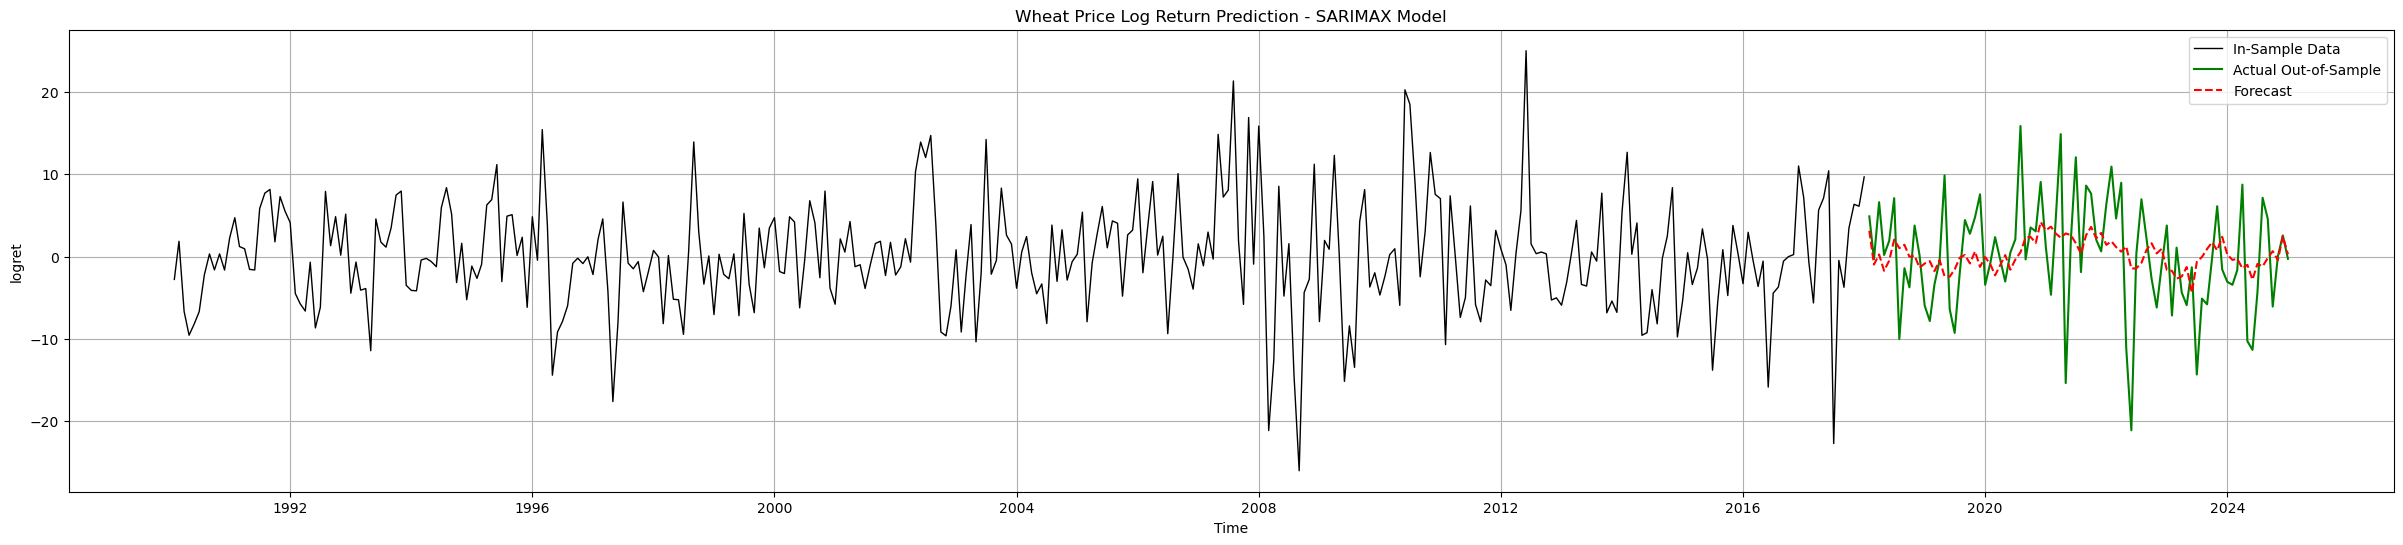

In [37]:
#plot predictions and forecast 
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, sarimax_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("Wheat Price Log Return Prediction - SARIMAX Model")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
#add lagged variables for deep learning models

#add extra lags for primary data values
primary_vars = ['corn_price_logret','drought_idx','fertilizer_idx_logret','commodity_imp_idx_logret','wheat_price_logret']
primary_lags = [1, 2, 3, 6, 12]
secondary_vars = ['crude_oil_price_logret', 'flour_price_logret']
secondary_lags = [1, 3, 6]

df_lagged = logret_df.copy()

# Create lags for primary variables
for var in primary_vars:
    for lag in primary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)

# Create lags for secondary variables
for var in secondary_vars:
    for lag in secondary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)
        
df_lagged = df_lagged.dropna()

#save month as datapoint
df_lagged['month'] = df_lagged.index.month
#add cyclical features (sin and cos of month)
logret_df['month_sin'] = np.sin(2 * np.pi * logret_df.index.month / 12)
logret_df['month_cos'] = np.cos(2 * np.pi * logret_df.index.month / 12)

df_lagged.head()

,fertilizer_idx_logret,cpi_logret,commodity_imp_idx_logret,commodity_exp_idx_logret,flour_price_logret,corn_price_logret,crude_oil_price_logret,wheat_price_logret,avg_temp,drought_idx,...,wheat_price_logret_lag_3,wheat_price_logret_lag_6,wheat_price_logret_lag_12,crude_oil_price_logret_lag_1,crude_oil_price_logret_lag_3,crude_oil_price_logret_lag_6,flour_price_logret_lag_1,flour_price_logret_lag_3,flour_price_logret_lag_6,month
date,,,,,,,,,,,,,,,,,,,,,
1991-02-01,0.076132,0.074212,-2.083409,-0.103359,-3.758271,0.743488,-20.858496,2.283945,0.704926,15.7,...,-1.615535,-6.689433,-4.246455,-7.812007,-10.863384,39.218856,3.333642,-3.758271,-1.941809,2
1991-03-01,-0.687288,0.000000,0.000000,-0.310720,0.000000,2.559569,-2.872907,4.725289,3.273592,8.2,...,0.325192,-2.225836,-2.777957,-20.858496,-16.984176,20.459097,-3.758271,0.424629,-2.381065,3
1991-04-01,-1.700196,0.222305,-0.845671,0.207254,0.847463,1.077216,4.567452,1.223253,9.166041,3.8,...,-1.636689,0.321023,1.860522,-2.872907,-7.812007,7.278553,0.000000,3.333642,-2.028467,4
1991-05-01,-1.808936,0.369413,-0.212540,-0.207254,-0.847463,-4.164077,1.902102,0.946878,14.906199,1.8,...,2.283945,-1.615535,-6.669145,4.567452,-20.858496,-10.863384,0.847463,-3.758271,-3.758271,5
1991-06-01,-1.923136,0.294551,-0.640344,-0.311689,0.847463,-0.590023,-5.022784,-1.556634,19.369806,1.4,...,4.725289,0.325192,-9.555649,1.902102,-2.872907,-16.984176,-0.847463,0.000000,0.424629,6


In [41]:
#save train and test set for lagged data
lagged_df_train = logret_df.loc[:'2018-01-01']

lagged_df_test = logret_df.loc['2018-02-01':]

X_train = lagged_df_train.drop(columns='wheat_price_logret_future')
X_test = lagged_df_test.drop(columns='wheat_price_logret_future')
y_train = lagged_df_train['wheat_price_logret_future']
y_test = lagged_df_test['wheat_price_logret_future']

In [43]:
from sklearn.tree import DecisionTreeRegressor
#run basic DT model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [45]:
#forecast for DT model
dt_forecast = dt_model.predict(X_test)
dt_forecast_series = pd.Series(dt_forecast, index=X_test.index, name='forecast')

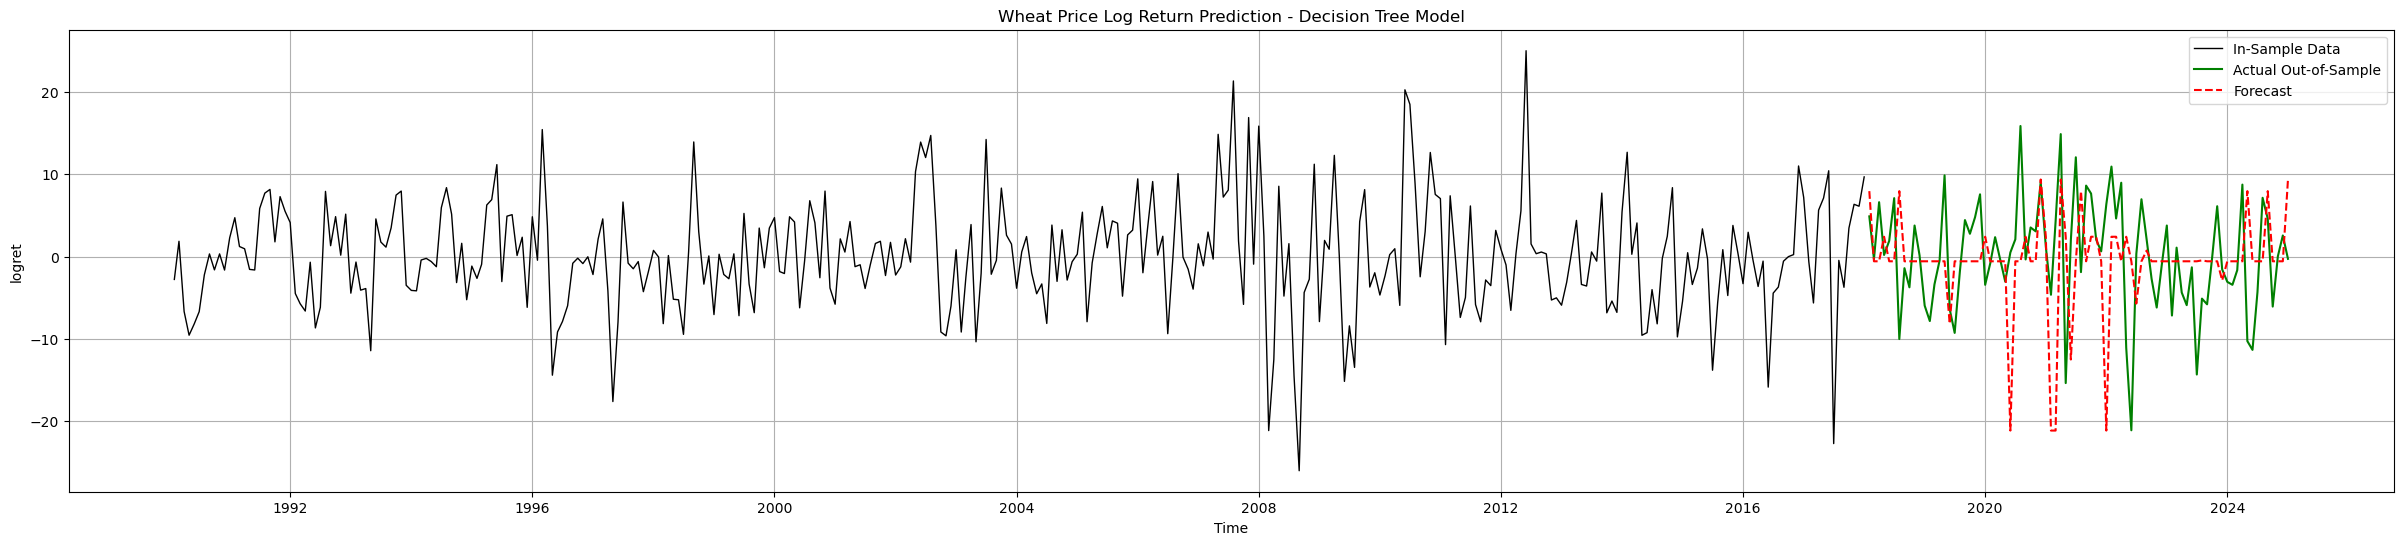

In [47]:
#plot DT predictions 
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, dt_forecast_series, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("Wheat Price Log Return Prediction - Decision Tree Model")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

#Hyperparameter tune for XGBoost model using gridsearch
tscv = TimeSeriesSplit(n_splits=5)

#Define parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42) #initialize

#grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
).fit(X_train,y_train)

#find and print best params
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9}


In [51]:
#initialize best model
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)
best_xgb.fit(X_train, y_train)

#Make predictions for XGBoost
xgb_forecast = best_xgb.predict(X_test)
xgb_forecast_series = pd.Series(xgb_forecast, index=X_test.index, name='forecast')

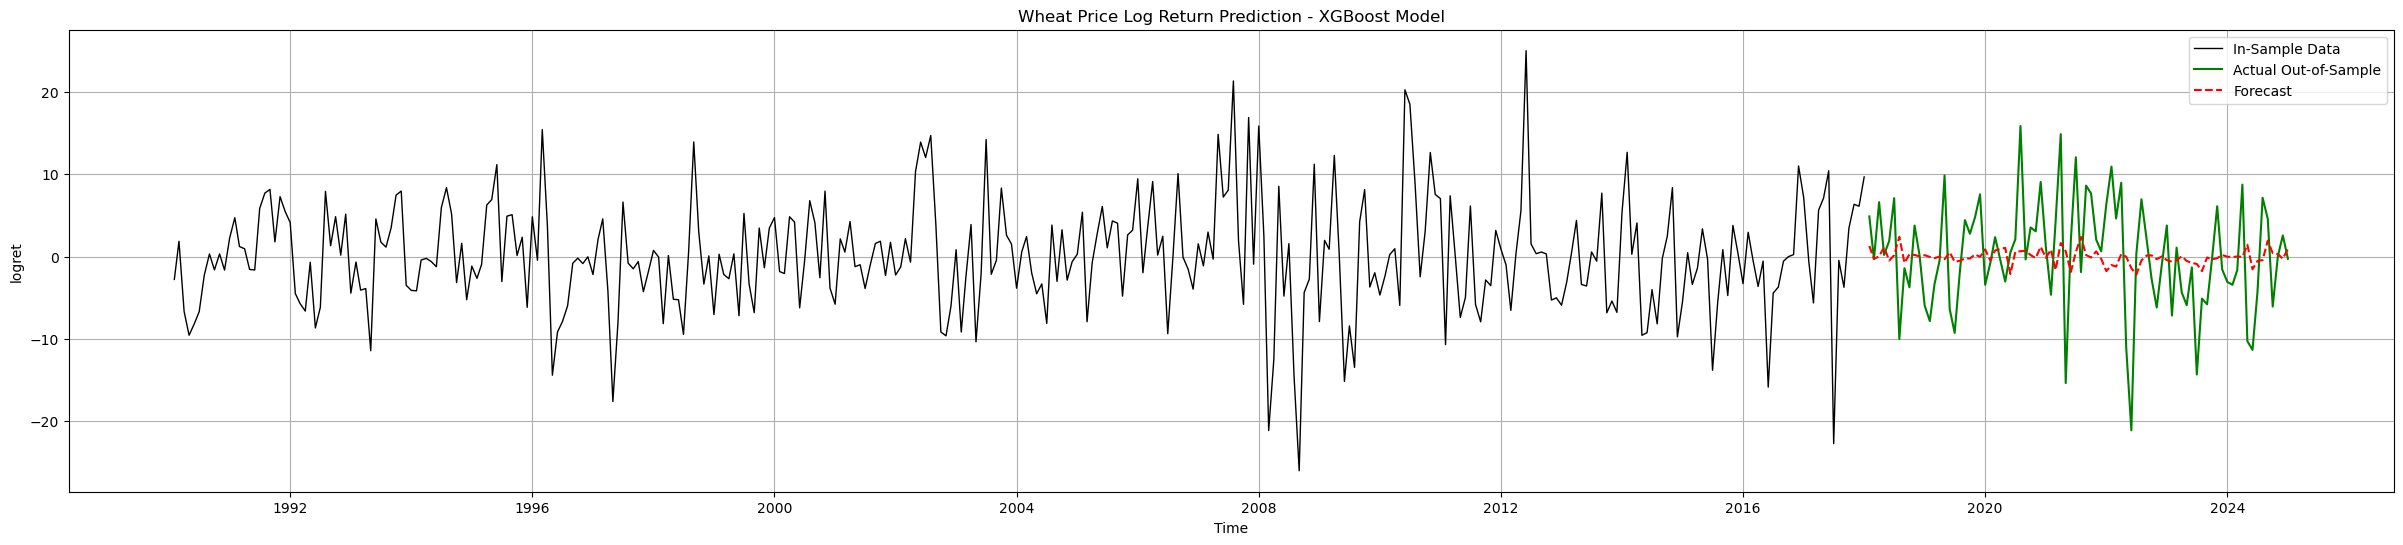

In [53]:
#plot XGBoost predictions 
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, xgb_forecast_series, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("Wheat Price Log Return Prediction - XGBoost Model")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
#print feature importance (top 10)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False).head(10)
print("\nTop 10 Most Important Features:")
print(feature_importance)


Top 10 Most Important Features:
                     Feature  Importance
7         wheat_price_logret    0.154978
11                 month_cos    0.117028
8                   avg_temp    0.104079
3   commodity_exp_idx_logret    0.100259
2   commodity_imp_idx_logret    0.090086
9                drought_idx    0.083007
6     crude_oil_price_logret    0.074612
5          corn_price_logret    0.067896
4         flour_price_logret    0.059365
1                 cpi_logret    0.052933


In [57]:
#test LSTM model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.vector_ar.var_model import VAR

#save features needed
lstm_features = ['wheat_price_logret', 'corn_price_logret', 'drought_idx', 
                'fertilizer_idx_logret', 'commodity_imp_idx_logret', 
                'commodity_exp_idx_logret', 'crude_oil_price_logret',
                'avg_temp', 'month_sin', 'month_cos']
lstm_data = logret_df[lstm_features + ['wheat_price_logret_future']].copy()

#scale data
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(lstm_data), 
                          columns=lstm_data.columns, 
                          index=lstm_data.index)

In [58]:
#prep LSTM model
sequence_length = 12
train_data = scaled_data.loc[:'2018-01-01']
test_data = scaled_data.loc['2018-02-01':]

#Create sequences for LSTM
X_train, y_train = [], []
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data.iloc[i:(i + sequence_length)].values)
    #Get target value (next month's wheat price log return)
    y_train.append(train_data.iloc[i + sequence_length]['wheat_price_logret_future'])

X_test, y_test = [], []
for i in range(len(test_data) - sequence_length):
    X_test.append(test_data.iloc[i:(i + sequence_length)].values)
    y_test.append(test_data.iloc[i + sequence_length]['wheat_price_logret_future'])
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [97]:
#Hyperparameter tune LSTM model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

#list of params
lstm_units = [50, 100]
dropout_rates = [0.2, 0.3]
learning_rates = [0.001, 0.0005]

results = []
best_rmse = float('inf')
best_model = None
best_params = None

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

#search for best model
for units in lstm_units:
    for dropout in dropout_rates:
        for lr in learning_rates:
            print(f"Training with: units={units}, dropout={dropout}, learning_rate={lr}")
            
            #Build model
            model = Sequential()
            model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(dropout))
            model.add(Dense(1))
            
            #Compile model
            model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
            
            #Train model
            history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stop],
                verbose=1
            )
            
            #Predict
            y_pred = model.predict(X_test)
            
            # Calculate RMSE
            dummy = np.zeros((len(y_pred), len(lstm_features) + 1))
            dummy[:, -1] = y_pred.flatten()
            y_pred_original = scaler.inverse_transform(dummy)[:, -1]
            dummy = np.zeros((len(y_test), len(lstm_features) + 1))
            dummy[:, -1] = y_test
            y_test_original = scaler.inverse_transform(dummy)[:, -1]
            rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
            mae = mean_absolute_error(y_test_original, y_pred_original)
            
            #Store results
            result = {
                'units': units,
                'dropout': dropout,
                'learning_rate': lr,
                'rmse': rmse,
                'mae': mae,
                'final_val_loss': history.history['val_loss'][-1],
                'epochs_used': len(history.history['loss'])
            }
            results.append(result)

            # Check if this is the best model
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_params = result
                print("New best model found!")

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results).sort_values('rmse')

#print best params
print("Best parameters:")
print(f"LSTM Units: {best_params['units']}")
print(f"Dropout Rate: {best_params['dropout']}")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with: units=50, dropout=0.2, learning_rate=0.001
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.4536 - val_loss: 0.0170
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - val_loss: 0.0472
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0525 - val_loss: 0.0182
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0371 - val_loss: 0.0206
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0299 - val_loss: 0.0167
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0315 - val_loss: 0.0185
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0280 - val_loss: 0.0167
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270 - val_loss: 0.0171
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0295 - val_loss: 0.0166
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274 - val_loss: 0.0167
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0268 - val_loss: 0.0166
Epoch 12/100
9/9 ━━━━━━━━━

In [99]:
from tensorflow.keras.models import Sequential
#train and test using best model
train_data = scaled_data.loc[:'2018-01-01']
test_data = scaled_data.loc['2018-02-01':]
seq_length = 12  # 12 months of history
X_train, y_train = [], []
for i in range(len(train_data) - seq_length):
    X_train.append(train_data.iloc[i:(i + seq_length)].values)
    y_train.append(train_data.iloc[i + seq_length]['wheat_price_logret_future'])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(len(test_data) - seq_length):
    X_test.append(test_data.iloc[i:(i + seq_length)].values)
    y_test.append(test_data.iloc[i + seq_length]['wheat_price_logret_future'])
X_test, y_test = np.array(X_test), np.array(y_test)

#Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=best_params['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(best_params['dropout']))
lstm_model.add(LSTM(best_params['units']))
lstm_model.add(Dropout(best_params['dropout']))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False
)
lstm_predictions_scaled = lstm_model.predict(X_test)

#get pred vals
dummy = np.zeros((len(lstm_predictions_scaled), len(lstm_data.columns)))
dummy[:, -1] = lstm_predictions_scaled.flatten()
inverse_dummy = scaler.inverse_transform(dummy)
lstm_predictions = inverse_dummy[:, -1]

#Create a Series with the predictions
lstm_forecast_series = pd.Series(
    lstm_predictions, 
    index=test_data.index[seq_length:],
    name='LSTM Forecast'
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1803 - val_loss: 0.0397
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0340 - val_loss: 0.0198
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0311 - val_loss: 0.0187
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0244 - val_loss: 0.0164
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0222 - val_loss: 0.0161
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - val_loss: 0.0169
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230 - val_loss: 0.0167
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0190 - val_loss: 0.0167
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0182 - val_loss: 0.0183
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195 - val_loss: 0.0170
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 - val_loss: 0.0185
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0201 - val_lo

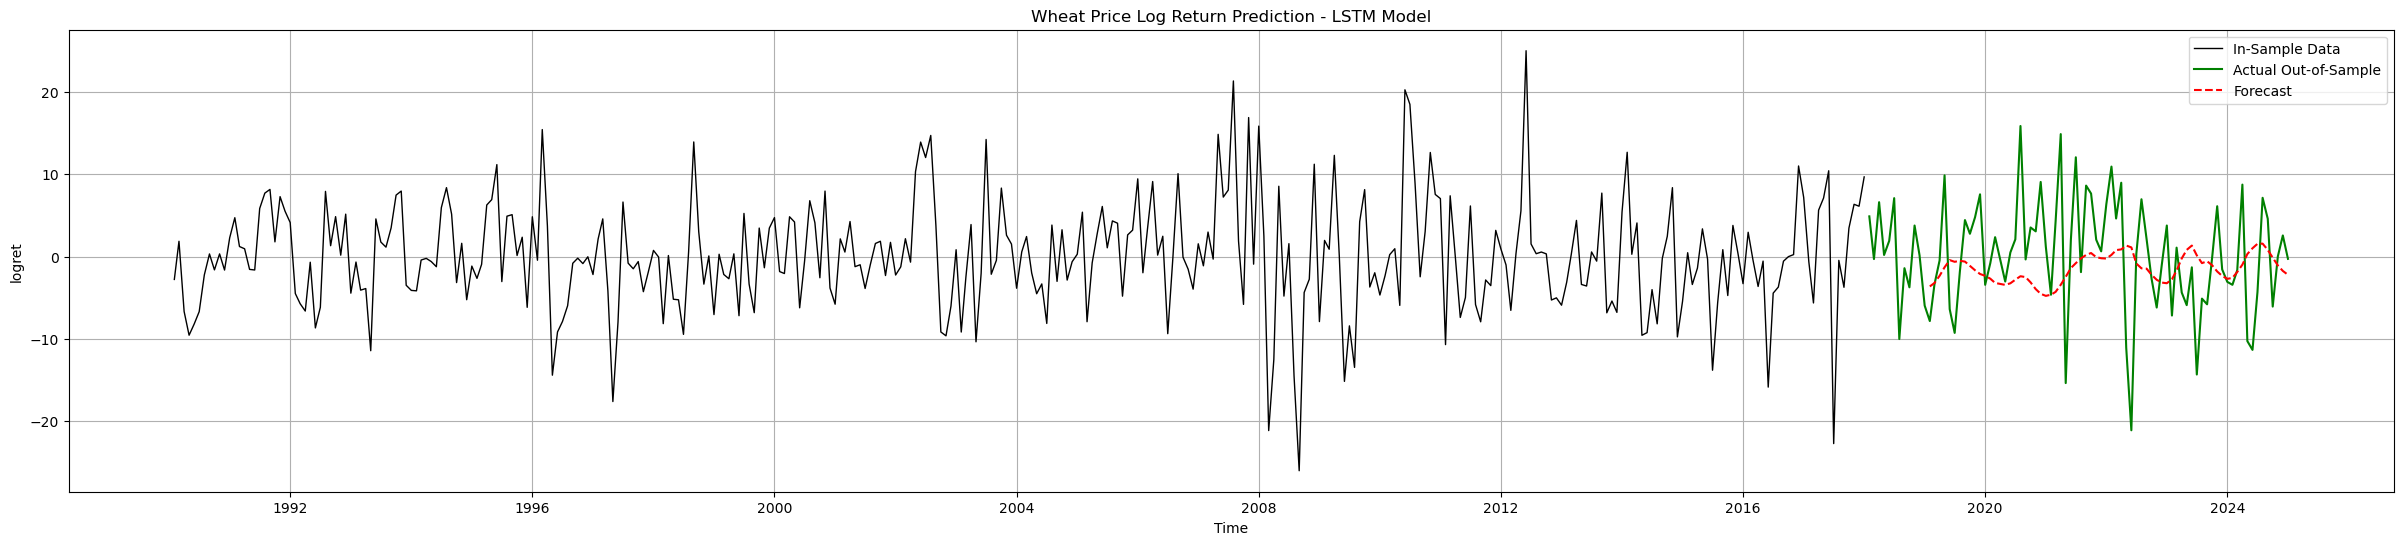

In [100]:
#plot predictions vs actual
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(lstm_forecast_series.index, lstm_forecast_series, label="Forecast", color="red", linestyle="dashed")

#format
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("Wheat Price Log Return Prediction - LSTM Model")
plt.legend()
plt.grid(True)
plt.show()

In [101]:
from statsmodels.tsa.vector_ar.var_model import VAR
#prep VAR model
var_features = ['wheat_price_logret', 'corn_price_logret', 'fertilizer_idx_logret', 
               'commodity_imp_idx_logret', 'commodity_exp_idx_logret', 
               'crude_oil_price_logret', 'wheat_price_logret_future']
var_data = logret_df[var_features].copy()

# Split into train/test sets
var_train = var_data.loc[:'2018-01-01']
var_test = var_data.loc['2018-02-01':]

#Fit VAR model
var_model = VAR(var_train)
#Select order based on AIC
var_results = var_model.select_order(maxlags=12)
var_order = var_results.selected_orders['aic']
print(f"Selected VAR order based on AIC: {var_order}")

#Fit model with best order
fitted_var_model = var_model.fit(var_order)
print(fitted_var_model.summary())

#Forecast
var_forecast_input = var_train.values[-var_order:]
var_forecast_steps = len(var_test)
var_forecast = fitted_var_model.forecast(y=var_forecast_input, steps=var_forecast_steps)

# Extract wheat price predictions
var_wheat_predictions = var_forecast[:, -1]

# Create a Series with the predictions
var_forecast_series = pd.Series(
    var_wheat_predictions, 
    index=var_test.index[:var_forecast_steps],
    name='VAR Forecast'
)

Selected VAR order based on AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, May, 2025
Time:                     17:13:56
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -54.8198
Nobs:                     335.000    HQIC:                  -55.2032
Log likelihood:           6017.71    FPE:                8.22570e-25
AIC:                     -55.4574    Det(Omega_mle):     6.97313e-25
--------------------------------------------------------------------
Results for equation wheat_price_logret
                                  coefficient       std. error                 t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                0.000000         0.000000                  0.011           0.992
L1.wheat_price_logret         

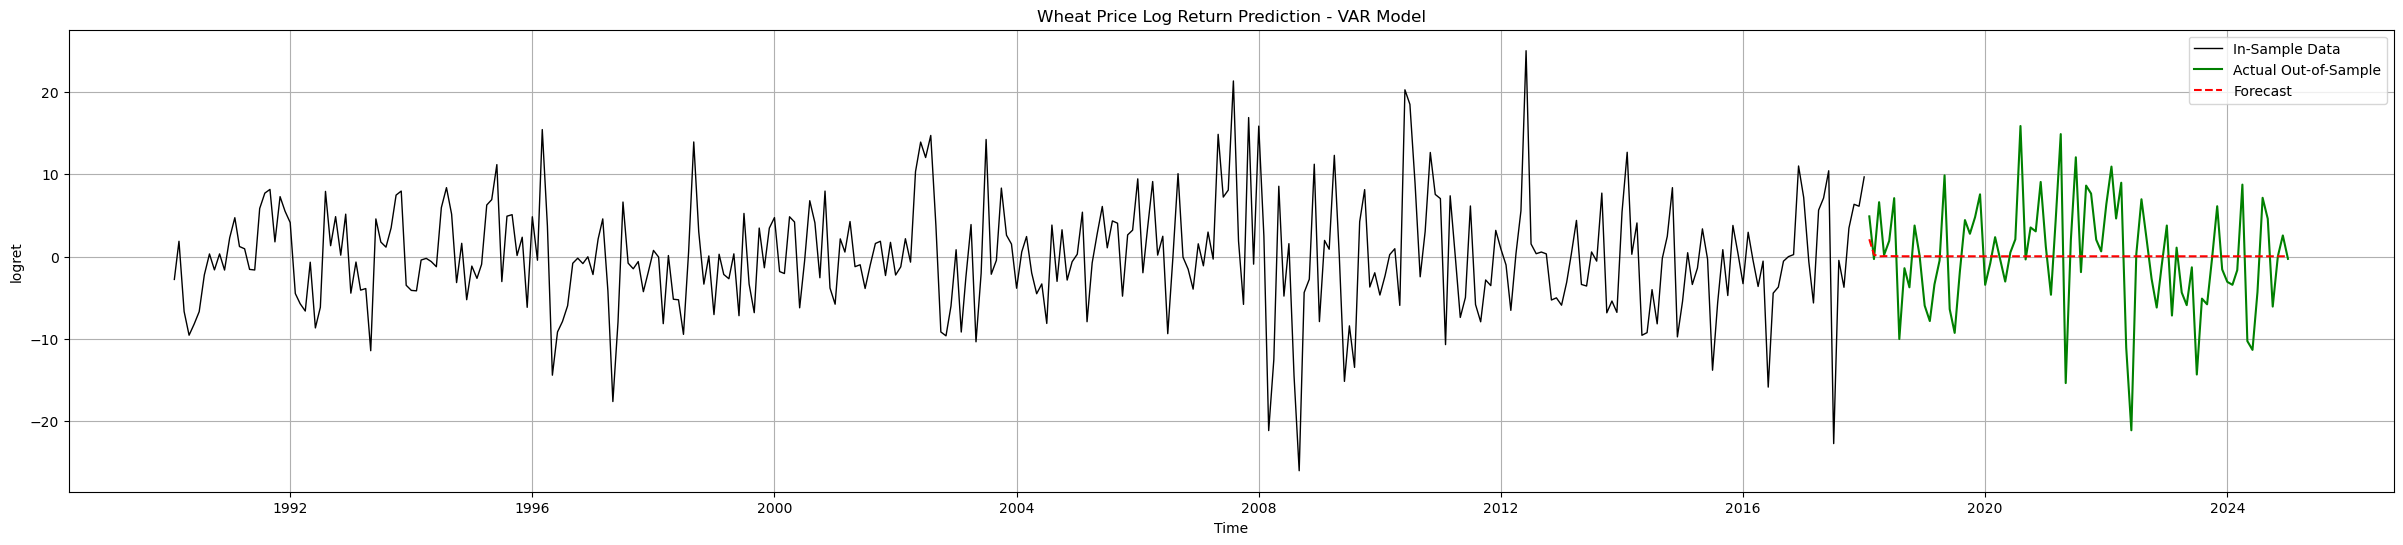

In [102]:
#plot predictions and actual values
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(var_forecast_series.index, var_forecast_series, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("Wheat Price Log Return Prediction - VAR Model")
plt.legend()
plt.grid(True)
plt.show()

In [103]:
#calculate mse, rmse, mae for LSTM and VAR models

#LSTM
lstm_rmse = np.sqrt(mean_squared_error(
    test_data.iloc[seq_length:]['wheat_price_logret_future'], 
    lstm_forecast_series
))
lstm_mae = mean_absolute_error(
    test_data.iloc[seq_length:]['wheat_price_logret_future'], 
    lstm_forecast_series
)
lstm_mse =mean_squared_error(
    test_data.iloc[seq_length:]['wheat_price_logret_future'], 
    lstm_forecast_series
)
#VAR
var_rmse = np.sqrt(mean_squared_error(
    var_test['wheat_price_logret_future'][:var_forecast_steps], 
    var_forecast_series
))
var_mae = mean_absolute_error(
    var_test['wheat_price_logret_future'][:var_forecast_steps], 
    var_forecast_series
)
var_mse=mean_squared_error(
    var_test['wheat_price_logret_future'][:var_forecast_steps], 
    var_forecast_series
)

In [104]:
#compare metrics between models
actual_values = logret_df_test_data["wheat_price_logret_future"]
forecasts = {
    'AutoReg': forecast_result_mean,
    'ARIMA': arima_forecast_result_mean,
    'SARIMAX': sarimax_forecast_result_mean,
    'Decision Tree': dt_forecast_series,
    'XGBoost': xgb_forecast_series
}

#Calculate metrics
results = []
for model_name, predicted_values in forecasts.items():
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predicted_values)
    
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })
results_df = pd.DataFrame(results).sort_values('RMSE')
new_df = pd.DataFrame([
    {'Model': 'VAR', 'MSE': var_mse, 'RMSE': var_rmse, 'MAE': var_mae},
    {'Model': 'LSTM', 'MSE': lstm_mse, 'RMSE': lstm_rmse, 'MAE': lstm_mae}
])
results_df = pd.concat([results_df, new_df], ignore_index=True).sort_values('RMSE')

#display
results_df

,Model,MSE,RMSE,MAE
6,LSTM,6.535068,2.556378,2.130480
0,SARIMAX,41.440526,6.437432,4.985091
1,ARIMA,41.878877,6.471389,4.933361
2,AutoReg,41.963986,6.477962,4.926149
3,XGBoost,44.387442,6.662390,5.238427
5,VAR,44.391910,6.662725,5.118948
4,Decision Tree,77.085196,8.779818,6.385832


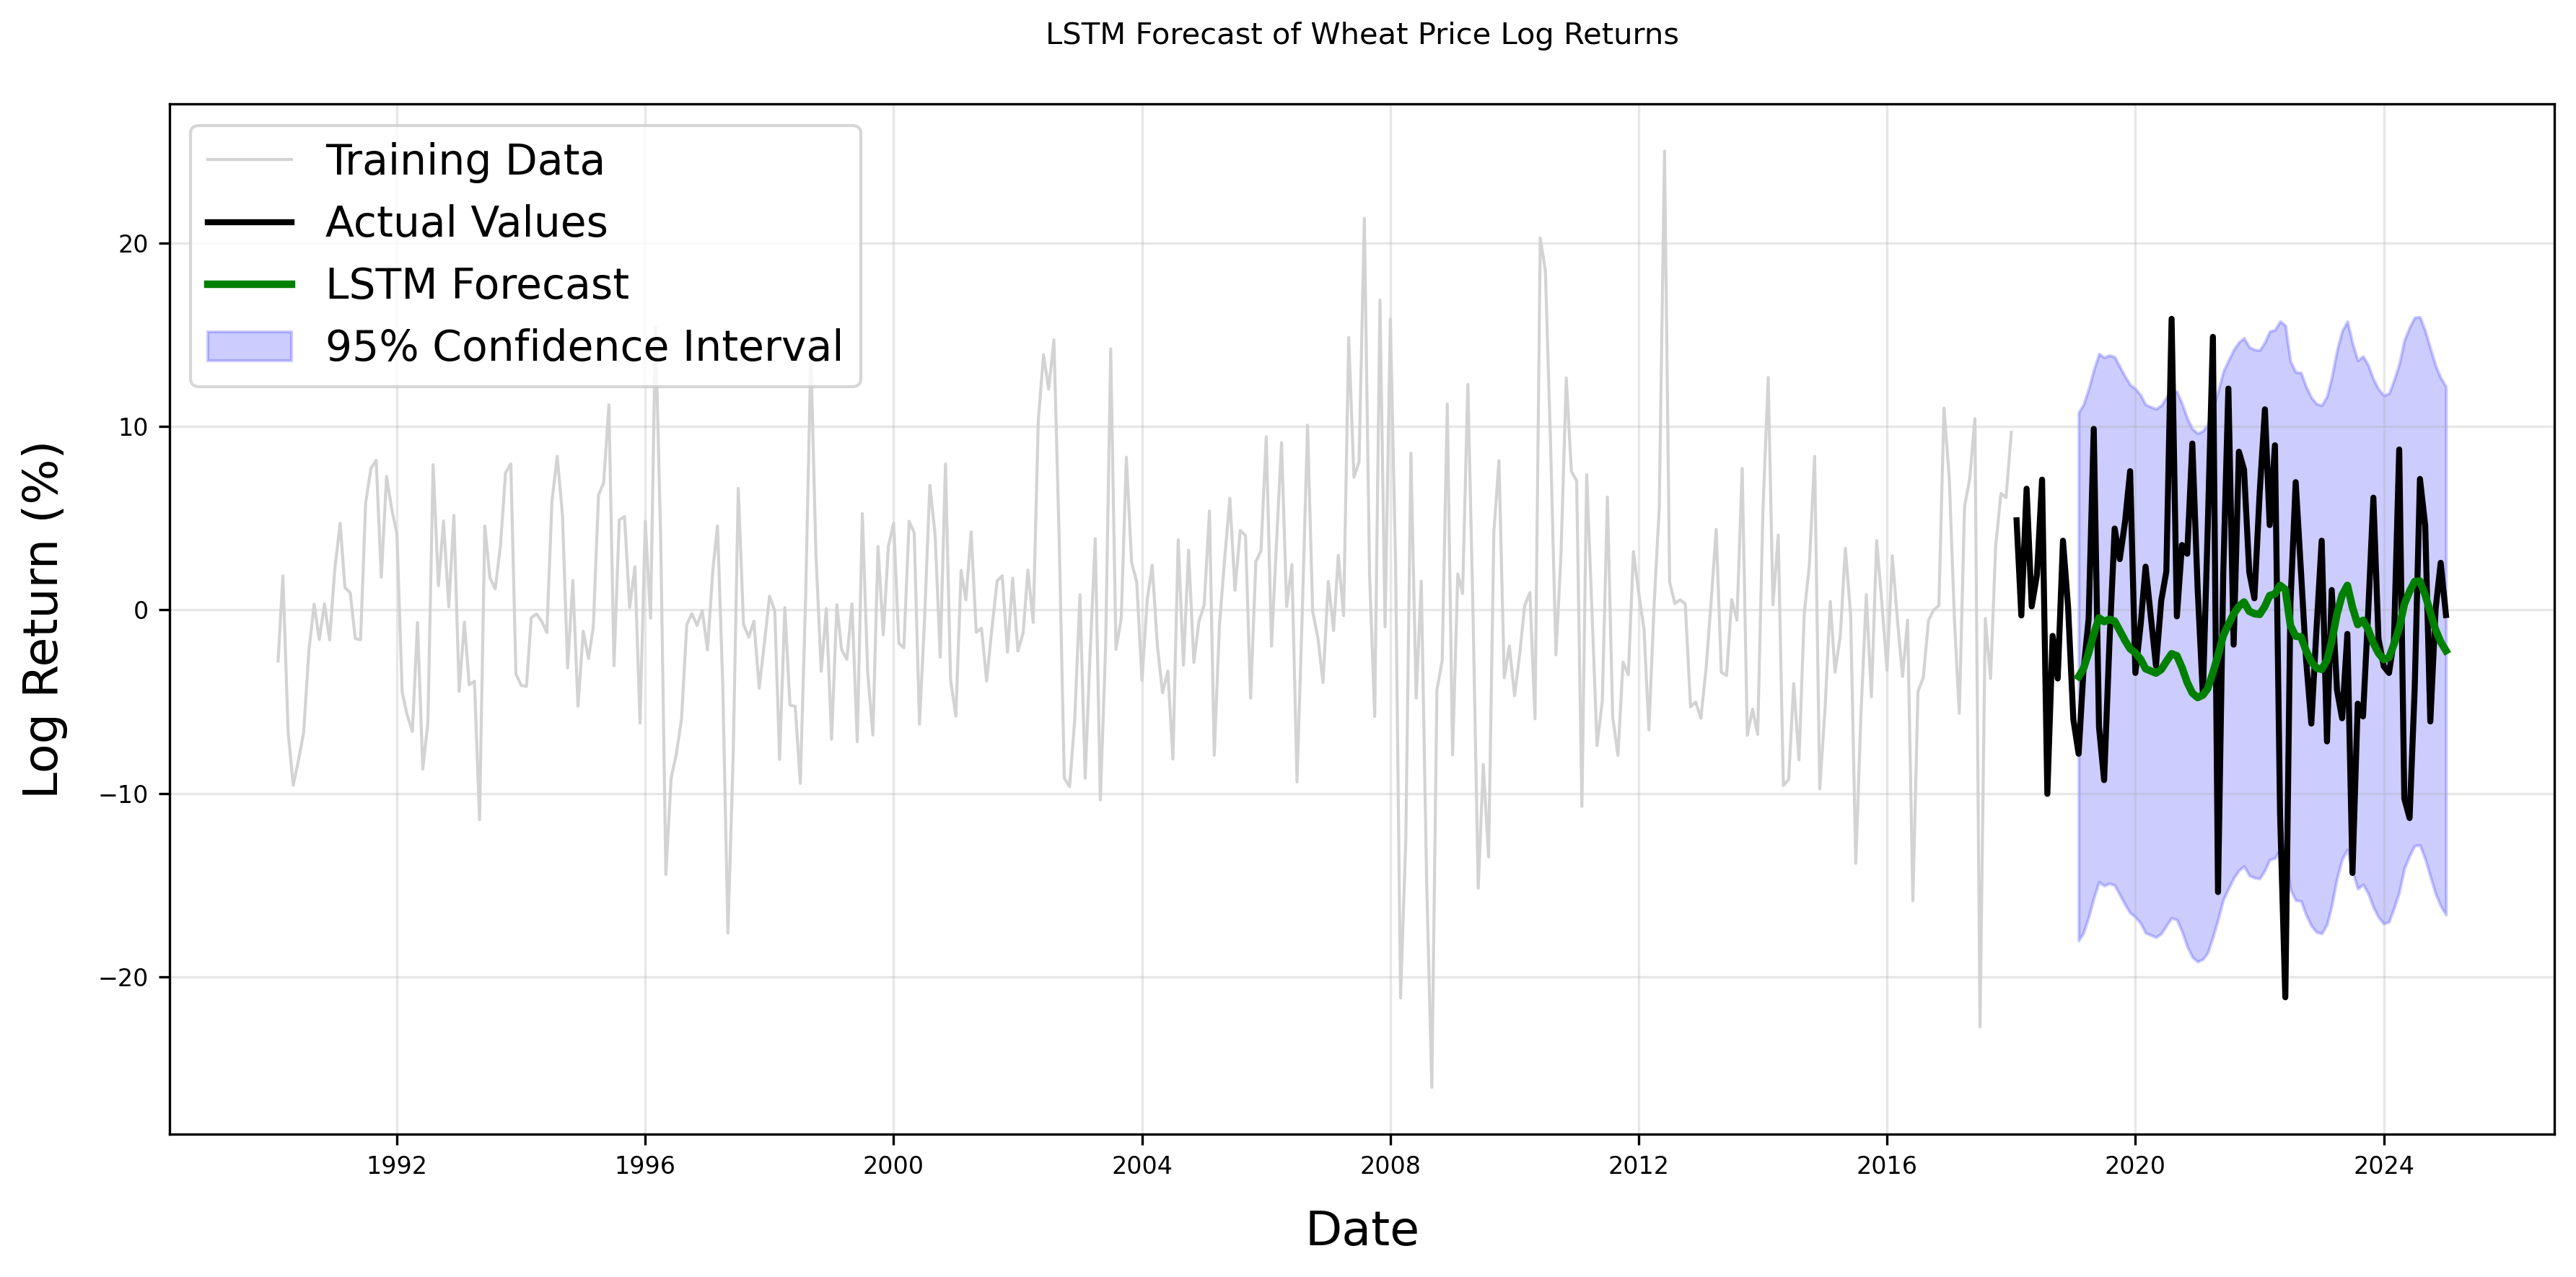

In [129]:
#Clean plot for best ML Model
plt.figure(figsize=(12, 6), dpi=300)

#Training  
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], 
         color="lightgray", linewidth=1, label="Training Data")

# Test and predictions
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], 
         color="black", linewidth=2, label="Actual Values")
plt.plot(lstm_forecast_series.index, lstm_forecast_series, 
         color="green", linewidth=2.5, label="LSTM Forecast")
#CI
std_dev = np.std(logret_df_test_data["wheat_price_logret_future"] - lstm_forecast_series)
plt.fill_between(lstm_forecast_series.index,
                 lstm_forecast_series - 1.96*std_dev,
                 lstm_forecast_series + 1.96*std_dev,
                 alpha=0.2, color="blue", label="95% Confidence Interval")
#title and format
plt.title("LSTM Forecast of Wheat Price Log Returns", fontsize=10, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=10)
plt.ylabel("Log Return (%)", fontsize=16, labelpad=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, loc="upper left")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('../Visualizations/LSTM_Forecast.png')
plt.show()

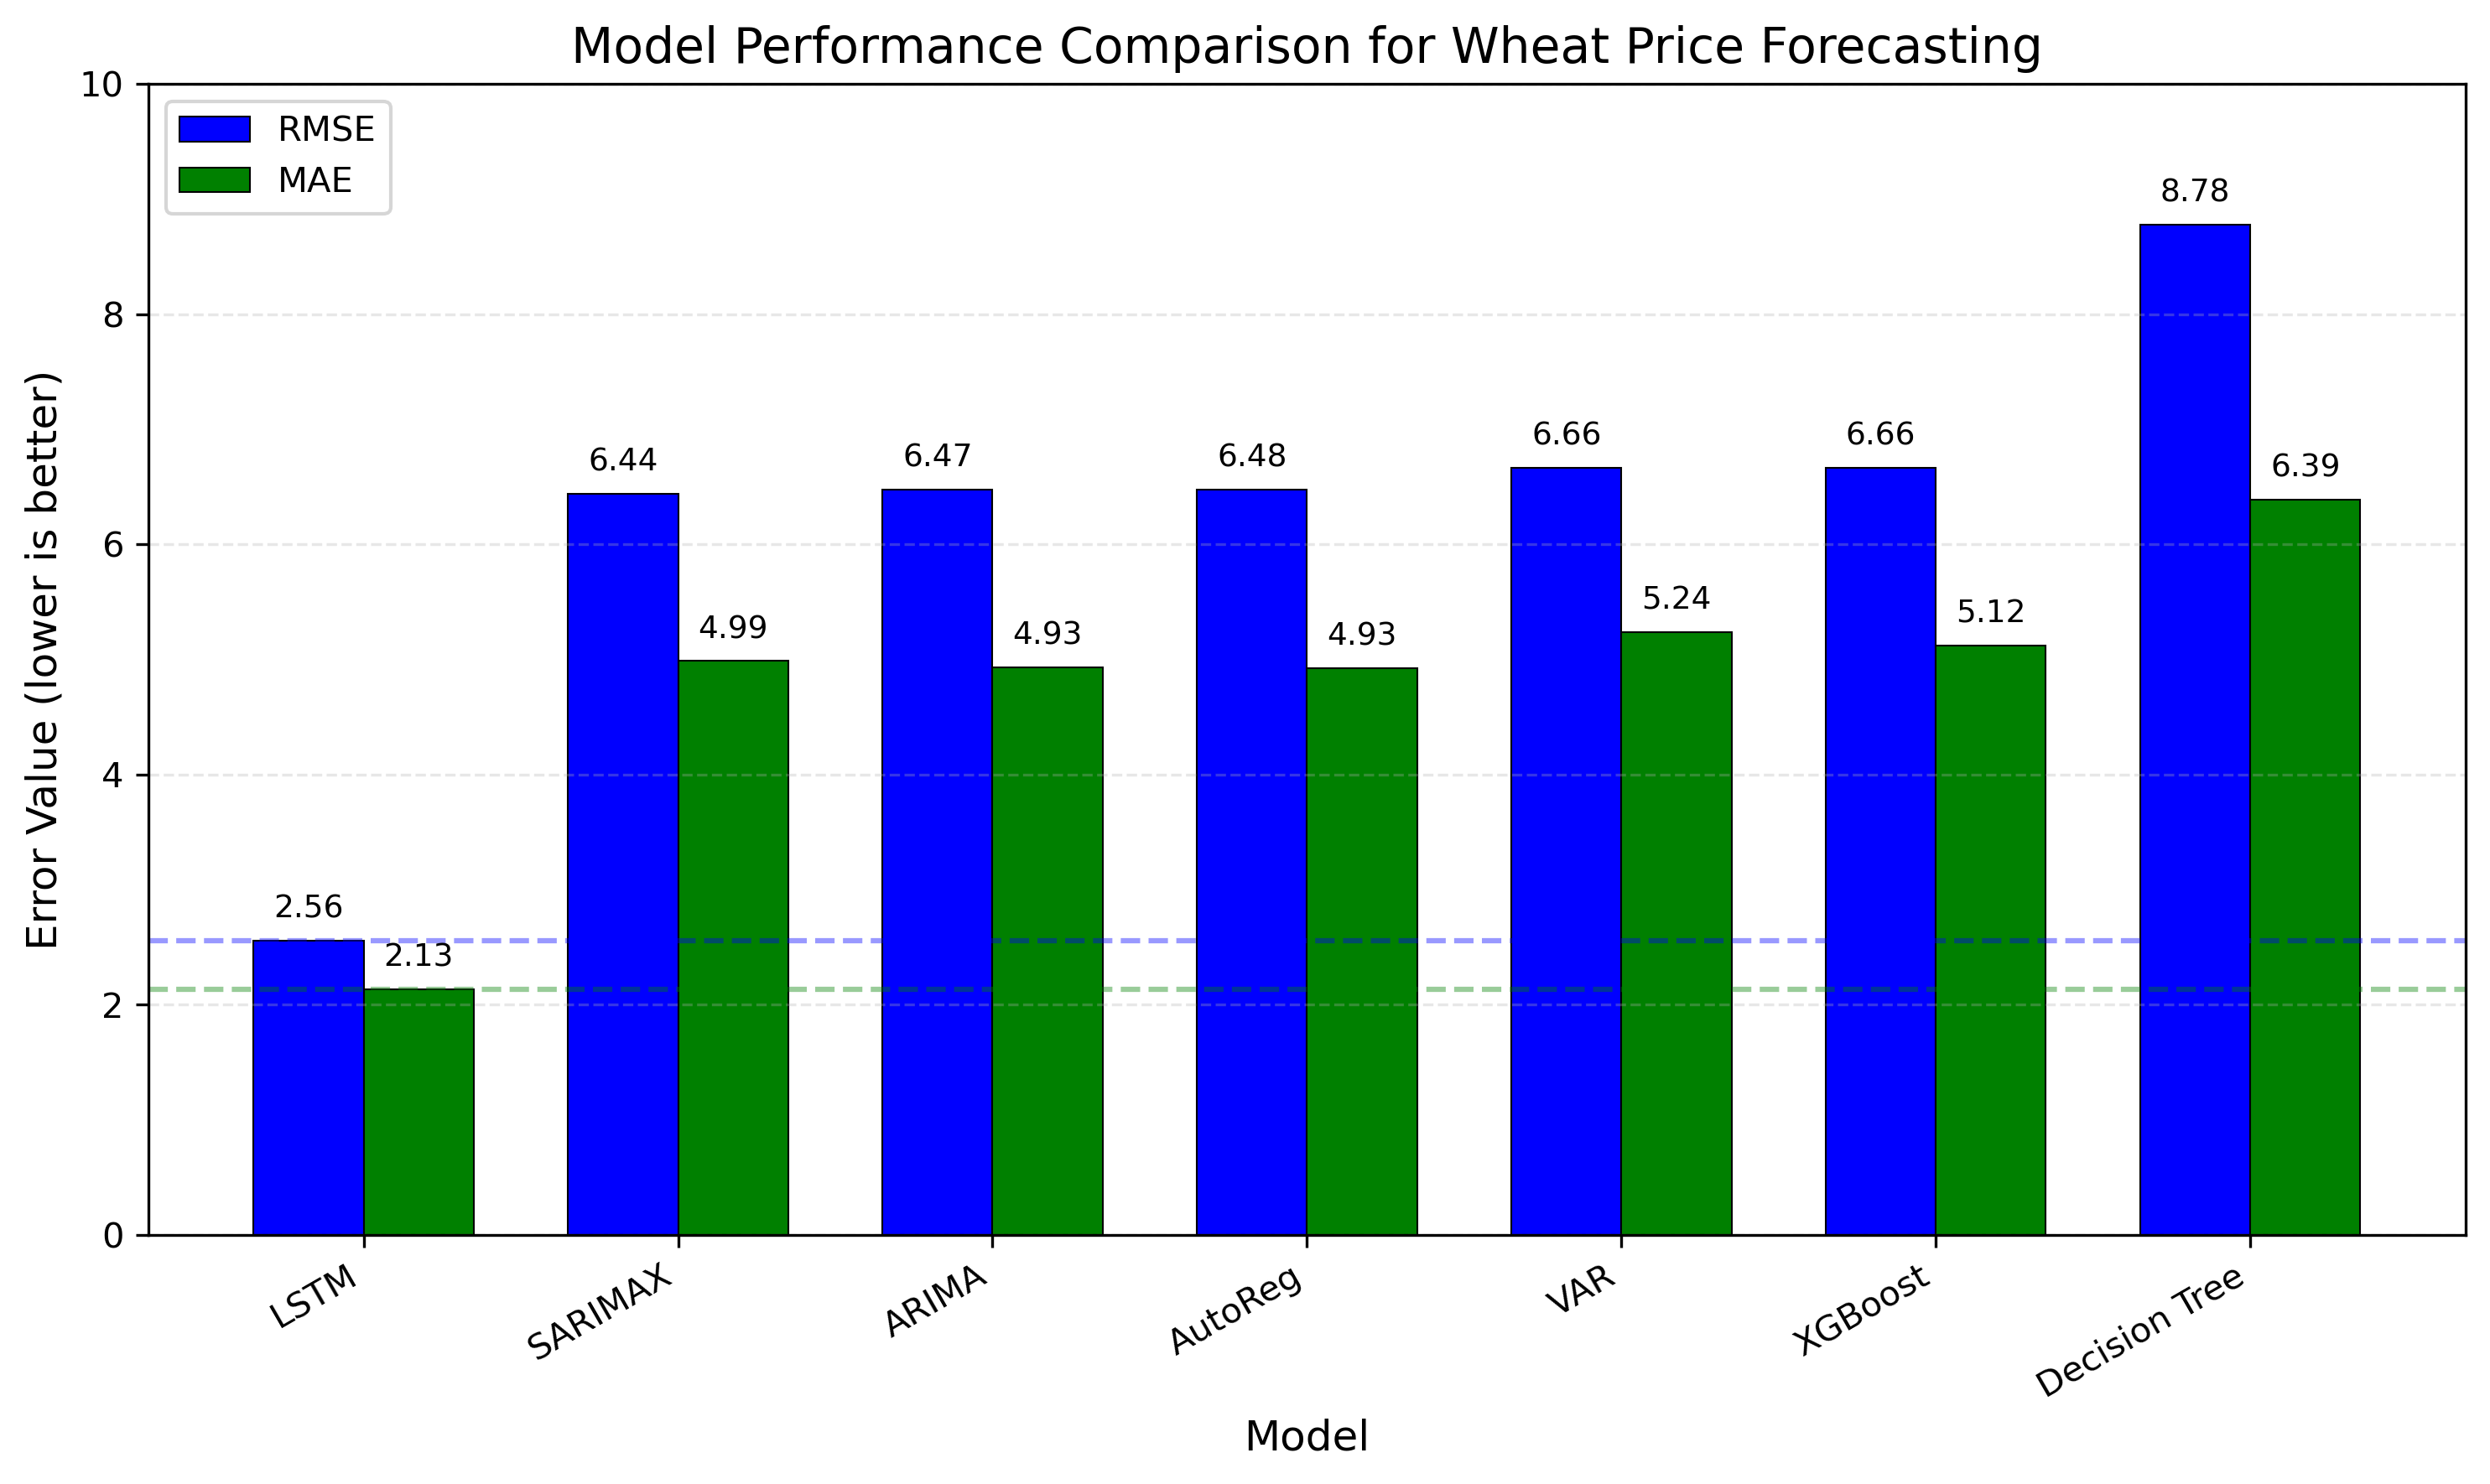

In [127]:
#compare model rmse and mae
models = ['LSTM', 'SARIMAX', 'ARIMA', 'AutoReg', 'VAR', 'XGBoost', 'Decision Tree'] #save model names
rmse_values = results_df['RMSE'] #save rmse
mae_values = results_df['MAE'] #save mae
plt.figure(figsize=(10, 6), dpi=300)
bar_width = 0.35
x = np.arange(len(models))

#Create bar graphs
bars1 = plt.bar(x - bar_width/2, rmse_values, bar_width, label='RMSE', 
                color='blue', edgecolor='black', linewidth=0.5)
bars2 = plt.bar(x + bar_width/2, mae_values, bar_width, label='MAE', 
                color='green', edgecolor='black', linewidth=0.5)


#Add text labels above each bar
for i, v in enumerate(rmse_values):
    plt.text(i - bar_width/2, v + 0.2, f"{v:.2f}", ha='center', fontsize=9)
    
for i, v in enumerate(mae_values):
    plt.text(i + bar_width/2, v + 0.2, f"{v:.2f}", ha='center', fontsize=9)

#Add horizontal lines showing best model 
plt.axhline(y=results_df['RMSE'][6], color='blue', linestyle='--', alpha=0.4)
plt.axhline(y=results_df['MAE'][6], color='green', linestyle='--', alpha=0.4)

# Format
plt.title('Model Performance Comparison for Wheat Price Forecasting', fontsize=14)
plt.ylabel('Error Value (lower is better)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(x, models, fontsize=10, rotation=30, ha='right')
plt.yticks(fontsize=10)
plt.ylim(0, 10)  # Adjust as needed
plt.legend(fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('../Visualizations/Final_Model_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

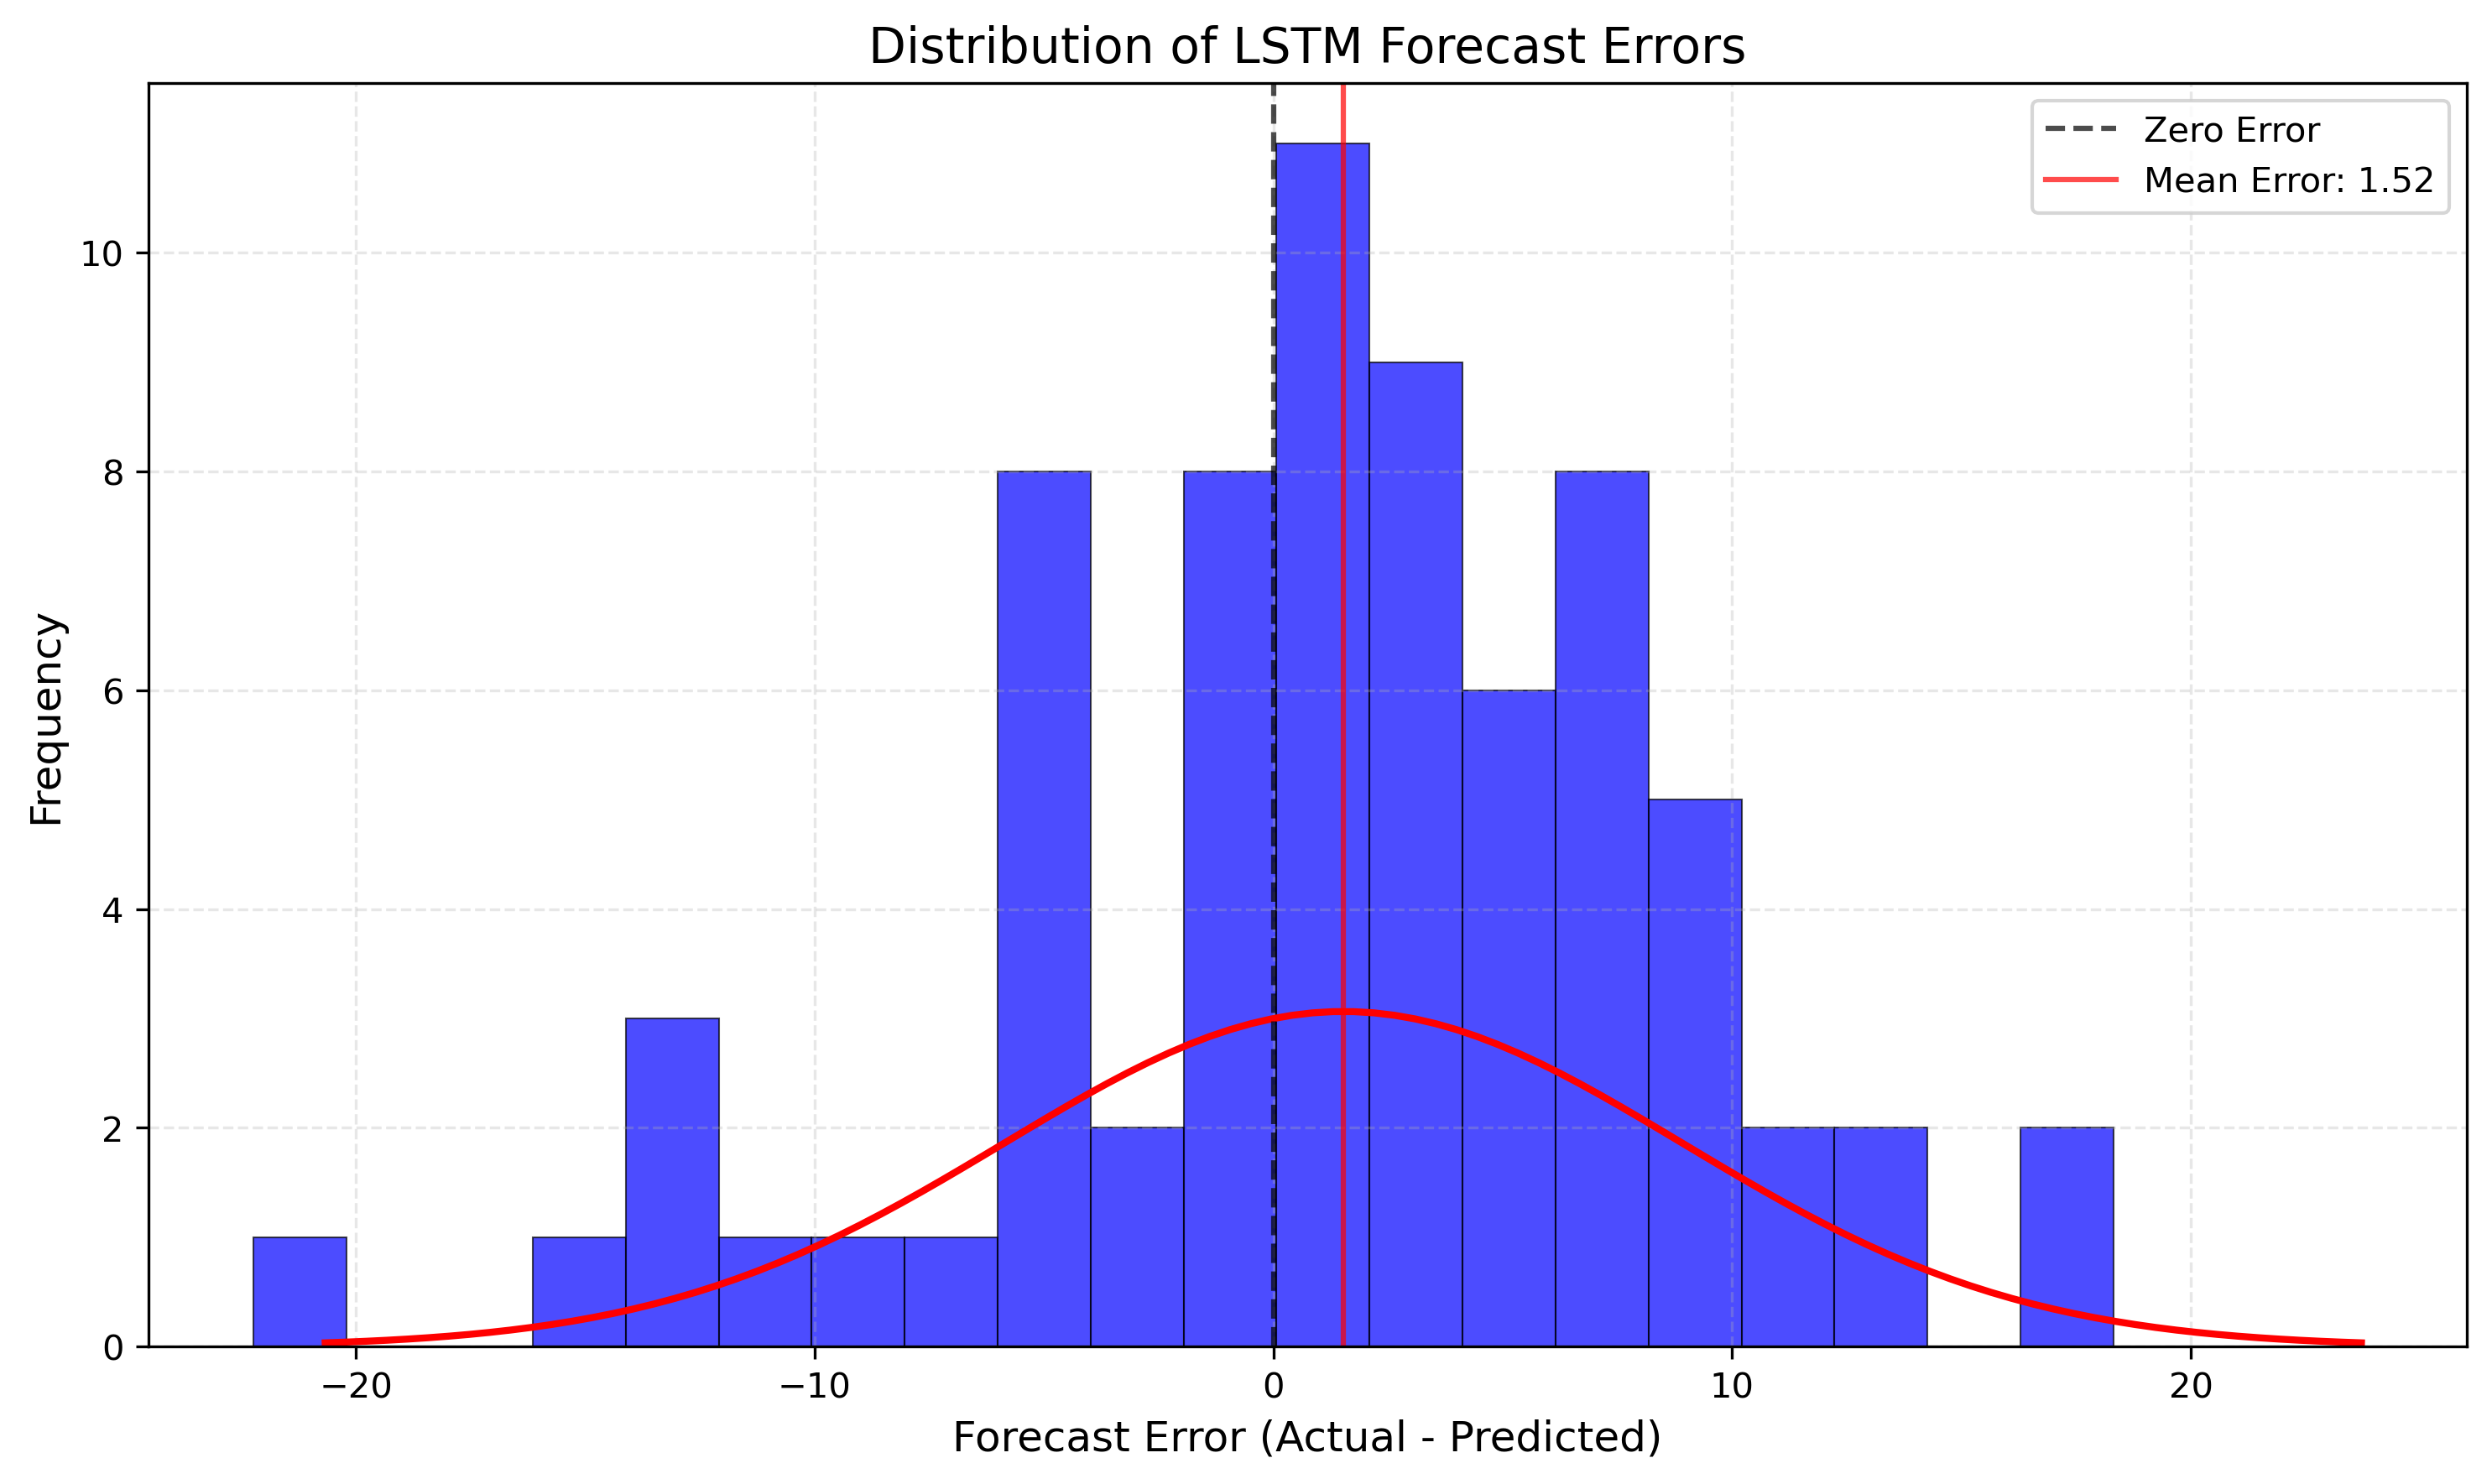

In [131]:
#Plot LSTM errors
forecast_errors = logret_df_test_data.loc[lstm_forecast_series.index, "wheat_price_logret_future"] - lstm_forecast_series
plt.figure(figsize=(10, 6), dpi=300)

#Create histogram
plt.hist(forecast_errors, bins=20, color='blue', alpha=0.7, edgecolor='black', linewidth=0.5)

#Add a curve showing the normal distribution
mu, sigma = forecast_errors.mean(), forecast_errors.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = len(forecast_errors) * 0.8 * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
plt.plot(x, y, 'r-', linewidth=2, color='red')

#Add vertical lines for mean and zero
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Zero Error')
plt.axvline(x=mu, color='red', linestyle='-', alpha=0.7, label=f'Mean Error: {mu:.2f}')

#Format the plot
plt.title('Distribution of LSTM Forecast Errors', fontsize=14)
plt.xlabel('Forecast Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('../Visualizations/LSTM_Forecast_Errors.png')
plt.show()

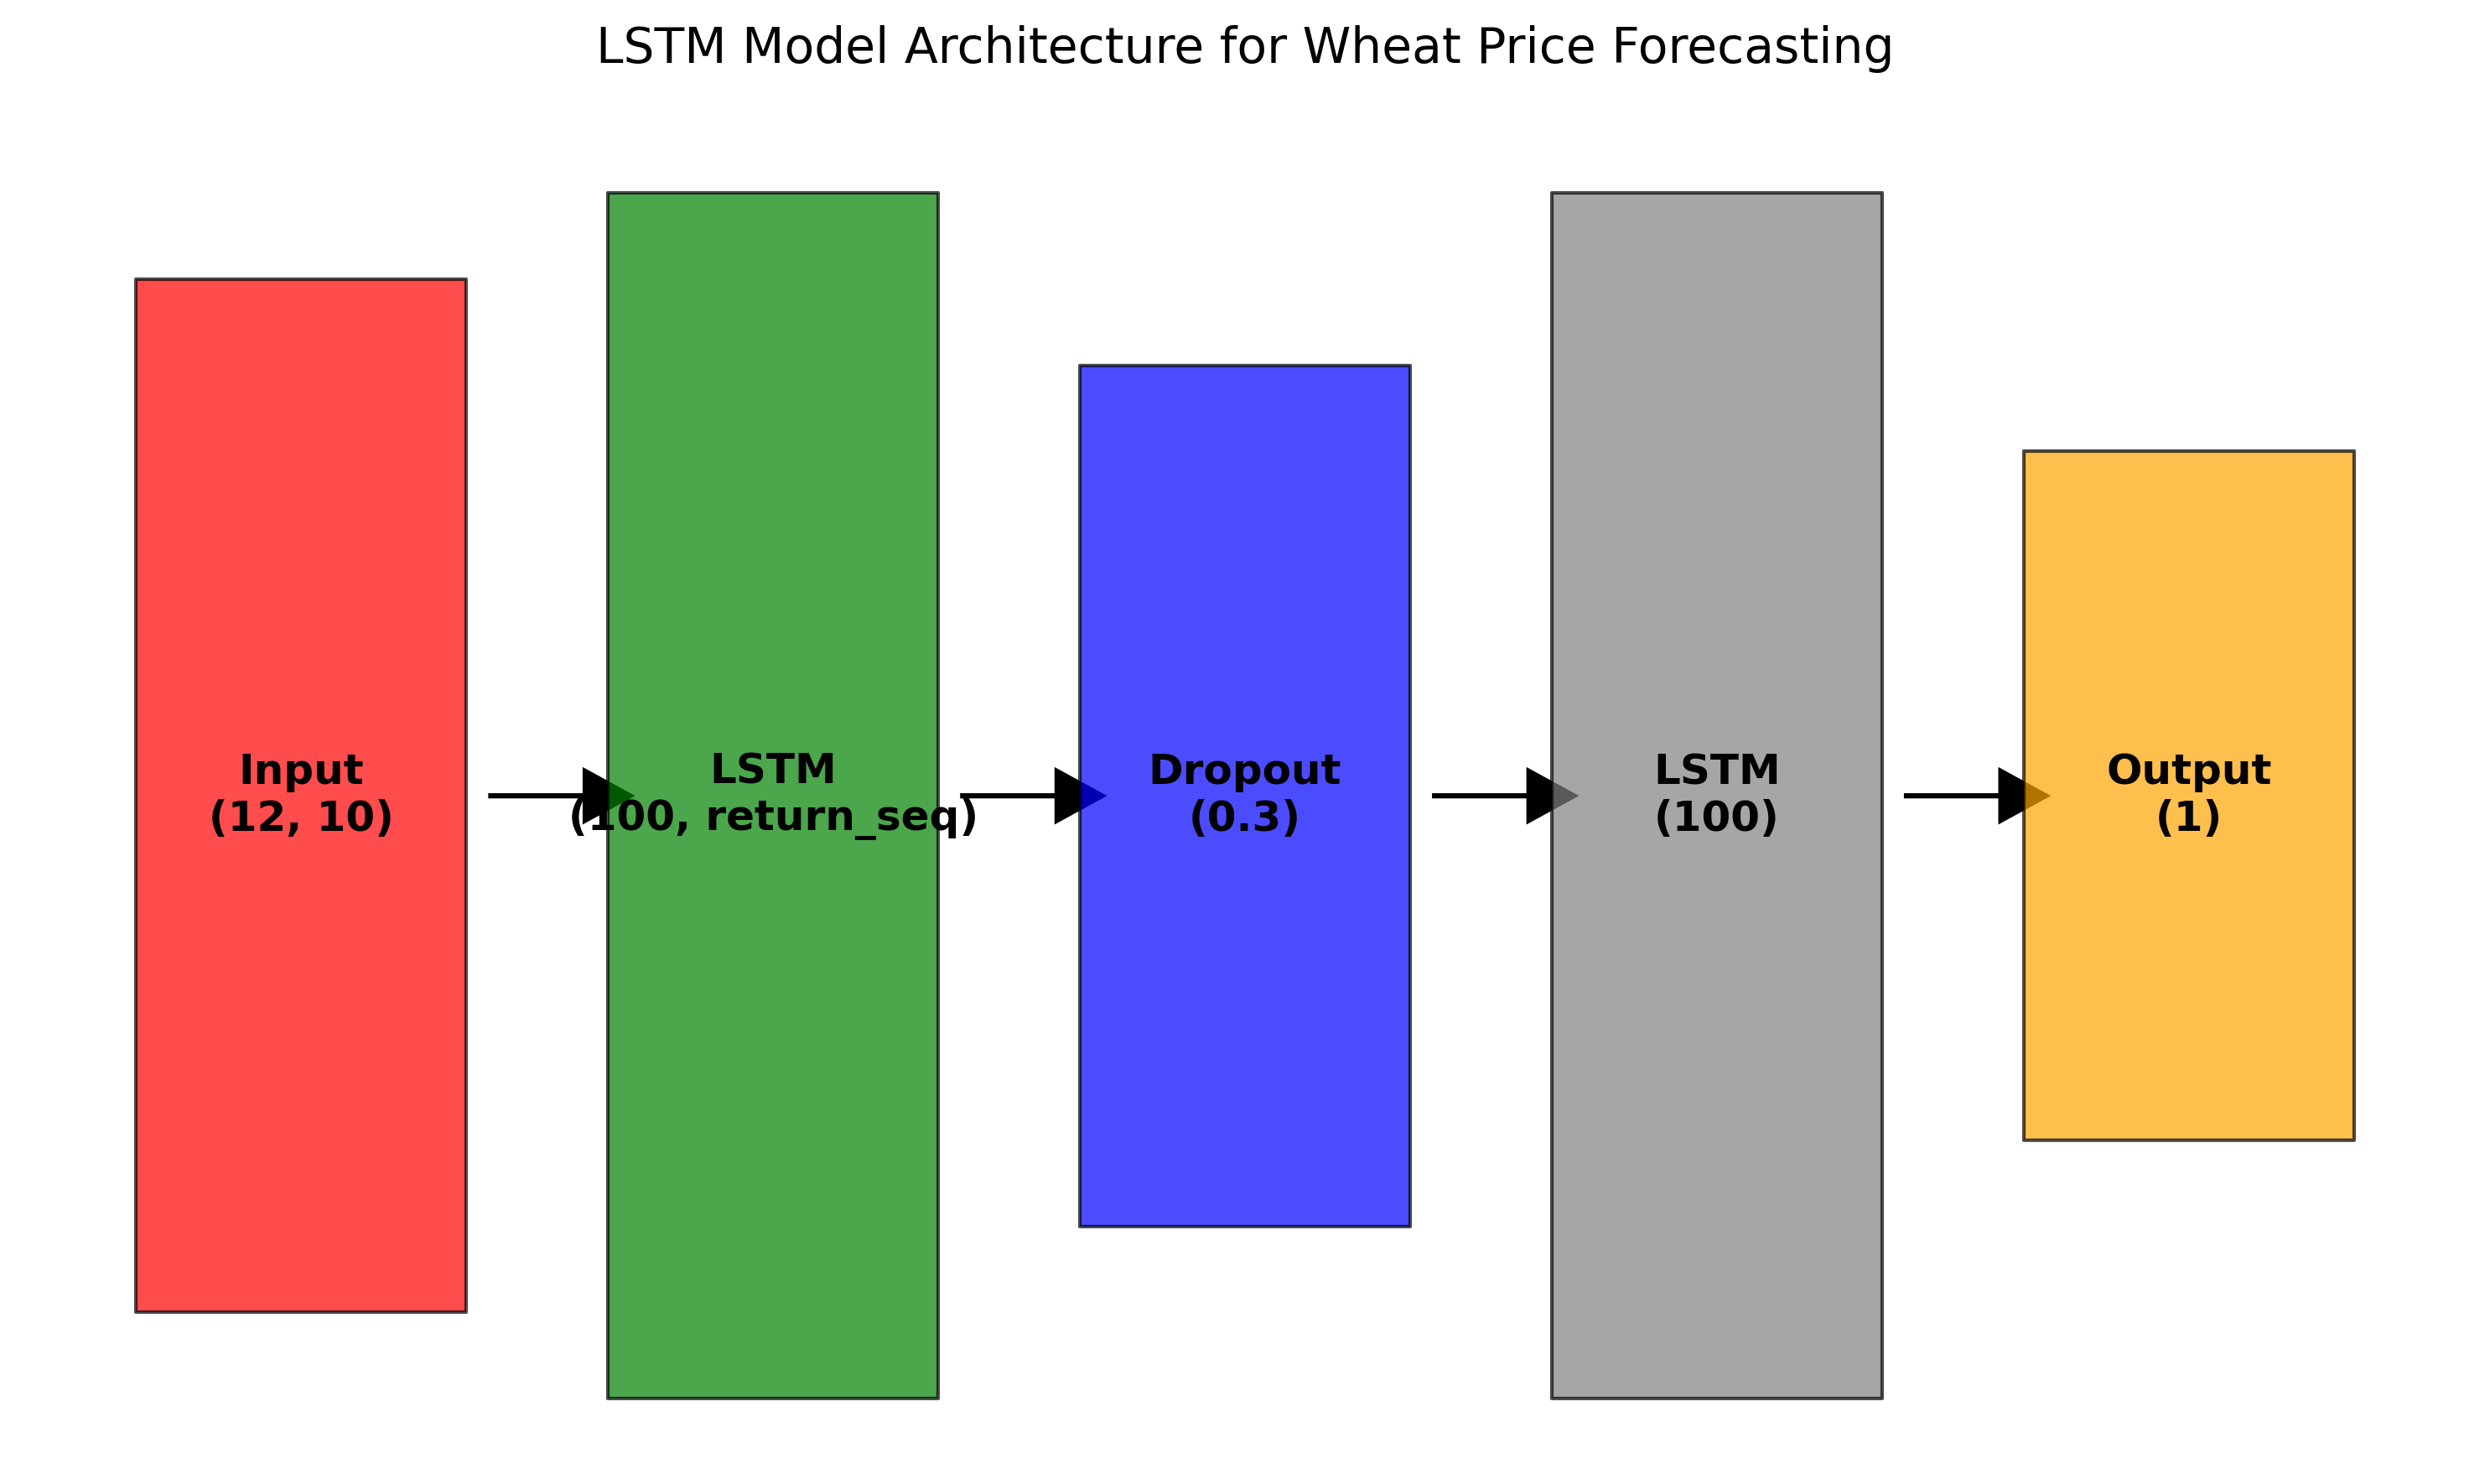

In [133]:
#plot layers for LSTM
fig = plt.figure(figsize=(10, 6), dpi=300)

#Define layer positions
layer_positions = [0.1, 0.3, 0.5, 0.7, 0.9]
layer_names = ['Input\n(12, 10)', 'LSTM\n(100, return_seq)', 'Dropout\n(0.3)', 'LSTM\n(100)', 'Output\n(1)']
layer_colors = ['red', 'green', 'blue', 'grey', 'orange']
layer_heights = [0.6, 0.7, 0.5, 0.7, 0.4]

# Draw layers
for i, (pos, name, color, height) in enumerate(zip(layer_positions, layer_names, layer_colors, layer_heights)):
    plt.fill_between([pos-0.07, pos+0.07], [0.5-height/2, 0.5-height/2], 
                    [0.5+height/2, 0.5+height/2], color=color, alpha=0.7,
                    edgecolor='black', linewidth=1)
    plt.text(pos, 0.5, name, ha='center', va='center', fontsize=12, fontweight='bold')
    
    #Add connecting arrows
    if i < len(layer_positions) - 1:
        plt.arrow(pos+0.08, 0.5, layer_positions[i+1]-pos-0.16, 0, 
                 head_width=0.03, head_length=0.02, fc='black', ec='black')

#Format
plt.title('LSTM Model Architecture for Wheat Price Forecasting', fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('../Visualizations/LSTM_Model_Architecture.png')
plt.show()